## Introduction
In this execise we will make a landuse classification using a Sentinel-2 image. We are going to use supervised classification algorithm to classify the landuse is 5 classes:
- water
- forest
- frass
- sand
- buildings

We will be using [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes). Naive Bayes predicts the probabilities that a data point belongs to a particular landuse class. The class with the highest probability is considered as the most likely class. The Naive Bayes implementation provided by the [scikit-learn](http://scikit-learn.org) library. `scikit-learn` is a machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including `numpy`, `scipy`, and `matplotlib`, which makes it very easy to incorporate into your workflow. 

This exercise is based on the Jupyter notebooks of Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

## Preparing the dataset
#### Opening the images
The first step is to import the modules we are going to use in this exercise and the landuse classes:

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from osgeo import gdal
from osgeo import gdalconst
from osgeo import ogr
from osgeo import gdalnumeric
from osgeo import gdal_array
import matplotlib.pyplot as plt
import plotly.express as px
import rasterio
from rasterio import features
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import os
import seaborn as sns
import pandas as pd

# Dictionary with landuse classes
class_dict = {}
landuse_classes_list = []
class_dict[1] = 'water'
class_dict[2] = 'forest'
class_dict[3] = 'sand'
class_dict[4] = 'grass'
class_dict[5] = 'buildings'
for key, value in class_dict.items() :
    landuse_classes_list.append(value) 

# Dictionary with colors for landuse classes
class_color_dict = {}
landuse_colors_list = []
class_color_dict['water'] = 'blue'
class_color_dict['forest'] = 'darkgreen'
class_color_dict['sand'] = 'gold'
class_color_dict['grass'] = 'limegreen'
class_color_dict['buildings'] = 'red' 
for landuse_class in landuse_classes_list :
    landuse_colors_list.append(class_color_dict[landuse_class]) 

# Folder with sentinel images 
sentinel_folder = "data_files/sentinel-2/"

# Names of the input files
shape_file_in     = 'data_files/ground_truth.shp'
raster_file_in    = 'data_files/sentinel-2/T31UFT_20190824T105031_B02_10m.tif'

# Name of new GeoTIFF file with all bands
sentinel_bands_file = 'data_files/sentinel_bands.tif'

# Name of new GeoTIFF file with groud truth sample areas
sample_areas_file = 'data_files/sample_areas.tif'


['water', 'forest', 'sand', 'grass', 'buildings']
['blue', 'darkgreen', 'gold', 'limegreen', 'red']


Now we need to collect all the Sentinel-2 bands because they come as individual images one per band. We merge them into one GeoTIFF image with multiple bands and we plot the image as false color composite for a visual inspection.

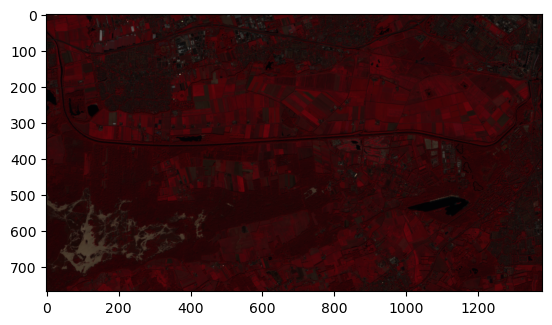

In [2]:
# Find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinel_folder, f) for f in os.listdir(sentinel_folder) if os.path.isfile(os.path.join(sentinel_folder, f))]
sentinal_band_paths.sort()
sentinal_band_paths

# Check to see if the dir it exists, if not, create it
if not os.path.exists(sentinel_folder):
    os.makedirs(sentinel_folder)

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(sentinel_bands_file, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

# Plot the FCC
raster = rasterio.open(sentinel_bands_file)

# Function to normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Close raster
raster = None

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)

# Stack bands
nrg = np.dstack((nir_norm, red_norm, green_norm))

# View the color composite
plt.imshow(nrg)


Now we need to rasterize the vector file with the sample areas (ground truth) we are going to use for training ang testing the model.

In [3]:
# Read ground_truth polygons
samples_areas = gpd.read_file(shape_file_in)

# Open raster and get metadata
rst = rasterio.open(raster_file_in)
meta = rst.meta.copy()
meta.update(compress='lzw')

# Here the magic takes place
with rasterio.open(sample_areas_file, 'w+', **meta) as out:
    out_arr = out.read(1)
    # This is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(samples_areas.geometry, samples_areas.id))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

# The rasterized file
print('The raster file sample areas: ' + str(sample_areas_file))

The raster file sample areas: data_files/sample_areas.tif


The following step is to determine the spectral reflectance curve for each landuse class. 

In [4]:
# Display rows, columns and number of bands
sentinel_bands = gdal.Open(sentinel_bands_file)
nr_of_cols     = sentinel_bands.RasterXSize
nr_of_rows     = sentinel_bands.RasterYSize
nr_of_bands    = sentinel_bands.RasterCount

# Store bands from satellite image in array   
sentinel_bands_array = np.zeros((nr_of_rows, nr_of_cols, nr_of_bands), gdal_array.GDALTypeCodeToNumericTypeCode(gdal.GDT_Int16))
for band_nr in range(nr_of_bands):
    sentinel_bands_array[:, :, band_nr] = sentinel_bands.GetRasterBand(band_nr + 1).ReadAsArray()

# Find how many non-zero entries we have -- i.e. how many training data samples?
sample_areas_ds = gdal.Open(sample_areas_file, gdal.GA_ReadOnly)
sample_areas_array = sample_areas_ds.GetRasterBand(1).ReadAsArray().astype(np.uint16)
n_samples = np.sum(sample_areas_array[(sample_areas_array > 0)])
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sample_areas_array[(sample_areas_array > 0)])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

# Maak nieuwe array waarbij je alleen de waardes selecteert waar een sample punt is
X = sentinel_bands_array[(sample_areas_array > 0), :]  
y = sample_areas_array[(sample_areas_array > 0)]


We have 10615 samples
The training data include 5 classes: [1 2 3 4 5]


Now that we have a list with the features (the 4 bands) and a list with labels (landuse classes) we can plot the spectral reflectance curve.

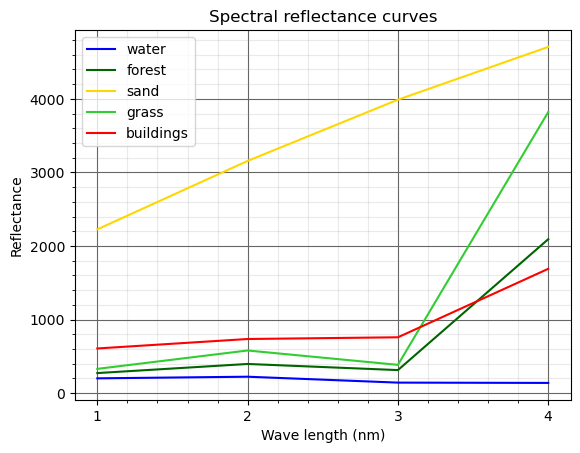

In [5]:
# Make array with number of bands
band_count = np.arange(1,nr_of_bands + 1)

# Calculate mean reflectance for each band in each class
classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    label = class_dict[class_type]
    plt.plot(band_count, band_intensity, label=label, color=class_color_dict[label])

# Annotation figure
plt.title('Spectral reflectance curves')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.legend(loc=0)
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('Wave length (nm)')
plt.ylabel('Reflectance')
plt.show()

The next step is to plot the landuse classes in as a function of the different bands. You can chage the colors of the points if you want. You can find the colors [here](https://community.plotly.com/t/plotly-colours-list/11730/3)

In [16]:
# Get bands
band_x_axis = X[:,0]
band_y_axis = X[:,3]

# Make list with landuse classes and colors to be used in plot
landuse_classes_names_array = []
for landuse_class in sample_areas_array[(sample_areas_array > 0)]:
   landuse_classes_names_array.append(class_dict[landuse_class])
   
# Make a Pandas dataframe
df = pd.DataFrame({'x':band_x_axis, 'y':band_y_axis, 'label':landuse_classes_names_array})

# Plot
cols = df['label'].map(class_color_dict)
fig = px.scatter(df, x="x", y="y", color='label', marginal_x='box', marginal_y='box', color_discrete_sequence=['red', 'limegreen','darkgreen','blue','gold'], labels = {"x" : "B02", "y" : "B08", })
fig.show()

# category_orders={"label": [True, False]}, color_discrete_sequence=["red", "lightgray"]


Accuracy: 0.9965891472868217
Our OOB prediction of accuracy is: 99.56584659913169%
[[ 670    0    0    0    0]
 [   0 1541    0    0    0]
 [   0    0  461    0    0]
 [   0    0    0  454    0]
 [   0   10    0    1   88]]


Text(86.24999999999999, 0.5, 'Actual')

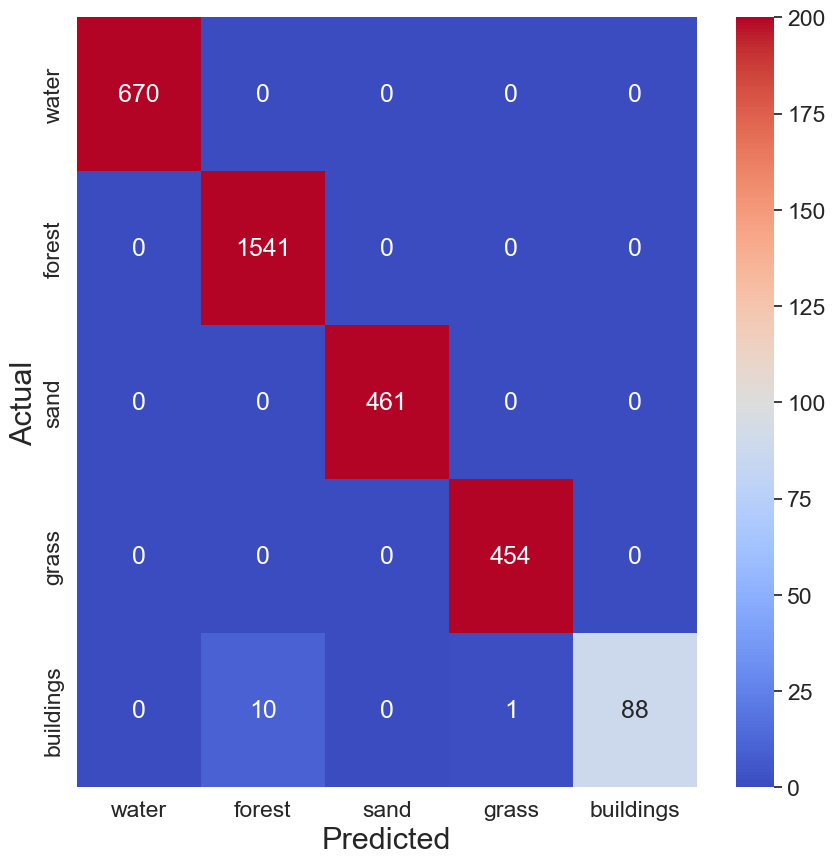

In [27]:
# Split the dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7) # 70% training and 30% test

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=50, oob_score=True)

# Train the model using the training sets 
rf.fit(X_train,y_train)

# Use the model to predict
y_pred = rf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Print prediction
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

# Confusion matrix to see how many points are correctly classified
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(conf_mat)
categories = ['water','forest','sand','grass','buildings']
conf_matrix_df = pd.DataFrame(conf_mat,columns=categories,index=categories)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,
            cmap='coolwarm',
            annot=True,
            fmt='.5g',
            vmax=200)

plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)


Okay we've successfully written it out now let's open it back up and make sure it meets our expectations:

In [ ]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print('Dimensions in rows, cols: ' + str(full_dataset.shape)) # dimensions
print('Number of bands: ' + str(full_dataset.count)) # bands

Let's take a look at the image just to make sure that it is on the right location:

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = full_dataset.read([2,1,1])[:,:,:]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords

In [ ]:
full_dataset.crs

Open the shapefile and check if crs is the same as crs from raster image.

In [ ]:
shapefile = gpd.read_file('data_files/ground_truth.shp')
shapefile.crs

Now we want to extract for the geometry of each feature the pixel values in 4 bands:

In [ ]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

Now let's extract the raster values values within the polygon using the rasterio [mask() function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html)

In [ ]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape



This is a training area of 4 bands and 29x77 pixels.

We'll be doing a lot of memory intensive work so let's clean up and close this dataset.

In [ ]:
full_dataset.close()

### Building the Training Data for `scikit-learn`

Now let's do it for all features in the shapefile and create an array `X` that has all the pixels and an array `y` that has all the training labels.


First step is to rasterize the shapefile with the ground truth polygons


In [ ]:
# Rasterize perceel to raster of satellite image
def rasterize_perceel( shape_file_name, raster_file_name) :

    # Open raster bestand en haal aantal rijen en kolommen op voor output raster bestand
    raster_file = gdal.Open(raster_file_name, gdalconst.GA_ReadOnly )
    nr_of_columns = raster_file.RasterXSize
    nr_of_rows    = raster_file.RasterYSize
    crs_wkt       = raster_file.GetProjection()

    # Read layer from shapefile
    driver = ogr.GetDriverByName('ESRI Shapefile')
    dataSource = driver.Open(shape_file_name, 0)
    outLayer = dataSource.GetLayer()
        
    # Maak leeg raster bestand met datatype Byte
    driver = gdal.GetDriverByName("GTiff")
    raster_file_name_ground_truth = r'data_files/ground_truth.tif'
    if os.path.isfile(raster_file_name_ground_truth) :
        os.remove(raster_file_name_ground_truth)
    raster_file_ground_truth = driver.Create(raster_file_name_ground_truth, nr_of_columns, nr_of_rows, 1, gdal.GDT_Byte)

    # Kopieer geotrans en coordinaatsysteem
    gdalnumeric.CopyDatasetInfo(raster_file, raster_file_ground_truth)

    # Initialize with NoData values
    NoData_value = 255
    raster_file_ground_truth.GetRasterBand(1).SetNoDataValue(NoData_value)
    raster_file_ground_truth.GetRasterBand(1).FlushCache()

    # Rasterize
    gdal.RasterizeLayer(raster_file_ground_truth, [1], outLayer, options=["ATTRIBUTE=id"])

    # Return name of generated rastefile
    raster_file = None
    raster_file_ground_truth = None
    return raster_file_name_ground_truth

# Call function
shape_file_in = 'data_files/ground_truth.shp'
raster_file_in = 'data_files/sentinel-2/T31UFT_20190824T105031_B02_10m.tif'
raster_file_ground_truth_name = rasterize_perceel( shape_file_in, raster_file_in)
print(raster_file_ground_truth_name)


The next step is to get the digital numbers for the different bands

In [ ]:
# Function to get all DN within perceel
# https://geowombat.readthedocs.io/en/latest/tutorial.html
# https://pygis.io/docs/f_rs_extraction.html#f-rs-extraction-point
# https://pygis.io/docs/f_rs_extraction.html#extracting-data-by-polygon-geometry

def get_dn_in_polygon_for_band(raster_file_gt_name, raster_file_band_name, landuse_class):
    
    # Open raster perceel file and rasterband
    raster_file_gt = gdal.Open(raster_file_gt_name)
    raster_file_gt_array = raster_file_gt.GetRasterBand(1).ReadAsArray()
    raster_file_band = gdal.Open(raster_file_band_name)
    raster_file_band_array_1 = raster_file_band.GetRasterBand(1).ReadAsArray()
    raster_file_band_array_2 = raster_file_band.GetRasterBand(2).ReadAsArray()
    raster_file_band_array_3 = raster_file_band.GetRasterBand(3).ReadAsArray()
    raster_file_band_array_4 = raster_file_band.GetRasterBand(4).ReadAsArray()

    # Iterate over perceel file and sample when value is 1 (due to warp you may have 0 value along edges, so ignore these)
    dn_out = []
    class_out = []
    for row in range(0, raster_file_gt_array.shape[0]):
        for col in range(0, raster_file_gt_array.shape[1]):
            if int(raster_file_gt_array[row,col]) == landuse_class :
                if int(raster_file_band_array_1[row,col]) > 0 :
                    dn_bands = []
                    dn_bands.append(int(raster_file_band_array_1[row,col]))
                    dn_bands.append(int(raster_file_band_array_2[row,col]))
                    dn_bands.append(int(raster_file_band_array_3[row,col]))
                    dn_bands.append(int(raster_file_band_array_4[row,col]))
                    dn_out.append(dn_bands)
 
    # Close files
    raster_file_gt = None
    raster_file_band = None

    # Return list with DN's for perceel and band
    return dn_out

# Call function
landuse_class = class_dict['water']
X1 = np.array(get_dn_in_polygon_for_band(raster_file_ground_truth_name, img_fp, landuse_class))
y1 = np.full((len(X1)), 'water')
landuse_class = class_dict['forest']
X2 = np.array(get_dn_in_polygon_for_band(raster_file_ground_truth_name, img_fp, landuse_class))
y2 = np.full((len(X2)), 'forest')
landuse_class = class_dict['sand']
X3 = np.array(get_dn_in_polygon_for_band(raster_file_ground_truth_name, img_fp, landuse_class))
y3 = np.full((len(X3)), 'sand')
landuse_class = class_dict['grass']
X4 = np.array(get_dn_in_polygon_for_band(raster_file_ground_truth_name, img_fp, landuse_class))
y4 = np.full((len(X4)), 'grass')
landuse_class = class_dict['buildings']
X5 = np.array(get_dn_in_polygon_for_band(raster_file_ground_truth_name, img_fp, landuse_class))
y5 = np.full((len(X5)), 'buildings')

X = np.concatenate((X1, X2, X3, X4, X5))
y = np.concatenate((y1, y2, y3, y4, y5))



In [ ]:
# Rasterize vector
import geopandas as gpd
import rasterio
from rasterio import features
shp_fn = 'data_files/ground_truth.shp'
rst_fn = 'data_files/sentinel-2/T31UFT_20190824T105031_B02_10m.tif'
out_fn = 'data_files/ground_truth_test.tif'

# Read ground_truth polygons
ground_truth_polygons = gpd.read_file(shp_fn)
print(ground_truth_polygons)

# Open raster
rst = rasterio.open(rst_fn)
meta = rst.meta.copy()
meta.update(compress='lzw')

with rasterio.open(out_fn, 'w+', **meta) as out:
    out_arr = out.read(1)
    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(ground_truth_polygons.geometry, ground_truth_polygons.id))
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

from osgeo import gdal_array
ground_truth_file = 'data_files/ground_truth.tif'
img_fp = 'data_files/sentinel_bands.tif'

# Display rows, columns and number of bands
img_bands   = gdal.Open(img_fp)
nr_of_cols  = img_bands.RasterXSize
nr_of_rows  = img_bands.RasterYSize
nr_of_bands = img_bands.RasterCount

# Store bands from satellite image in araay   
img = np.zeros((nr_of_rows, nr_of_cols, nr_of_bands), gdal_array.GDALTypeCodeToNumericTypeCode(gdal.GDT_Int16))

for band_nr in range(nr_of_bands):
    img[:, :, band_nr] = img_bands.GetRasterBand(band_nr + 1).ReadAsArray()

# Find how many non-zero entries we have -- i.e. how many training data samples?
ground_truth_ds = gdal.Open(ground_truth_file, gdal.GA_ReadOnly)
ground_truth_array = ground_truth_ds.GetRasterBand(1).ReadAsArray().astype(np.uint16)
n_samples = np.sum(ground_truth_array[(ground_truth_array > 0) & (ground_truth_array < 255)])
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(ground_truth_array[(ground_truth_array > 0) & (ground_truth_array < 255)])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

# Maak nieuwe array waarbij je alleen de waardes selecteert waar een sample punt is
X = img[(ground_truth_array > 0) & (ground_truth_array < 255), :]  
y = ground_truth_array[(ground_truth_array > 0) & (ground_truth_array < 255)]

print(X)
print(y)

In [ ]:
X = np.array([], dtype=np.int8).reshape(0,4) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        #print(out_image)
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        #print(out_image_reshaped)
        # append the labels to the y array
        y = np.append(y,[shapefile["landuse"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))  
        print(X)
        #print(y)
  

#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the land cover labels (our y labeled data), let's check to make sure they match in size so we can feed them to Naive Bayes:

In [ ]:
# What are our classification labels?
labels = np.unique(shapefile["landuse"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))


It all looks good! Let's explore the spectral signatures of each class now to make sure they're actually separable since all we're going by in this classification is pixel values.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1,5)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
# plot them as lines



# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
#ax.set
ax[0].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')


They look okay but emergent wetland and water look quite similar! They're going to be difficult to differentiate.

Let's make a quick helper function, this one will convert the class labels into indicies and then assign a dictionary relating the class indices and their names.

## Training the Classifier
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of GaussianNaiveBayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) from `scikit-learn`.

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

It is that simple to train a classifier in `scikit-learn`! The hard part is often validation and interpretation.

## Predicting on the image

With our Naive Bayes classifier fit, we can now proceed by trying to classify the entire image:

We're only going to open the subset of the image we viewed above because otherwise it is computationally too intensive for most users.

In [ ]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [ ]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 150:600, 250:1400]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

Now we can predict for each pixel in our image:

In [ ]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

Because our shapefile came with the labels as strings we want to convert them to a numpy array with ints using the helper function we made earlier.

In [ ]:
class_prediction = str_class_to_int(class_prediction)

### Let's visualize it!

First we'll make a colormap so we can visualize the classes, which are just encoded as integers, in more logical colors. Don't worry too much if this code is confusing! It can be a little clunky to specify colormaps for `matplotlib`.

In [ ]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

Now show the classified map next to the RGB image!

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

fig.show()

### This looks pretty good!

Let's generate a map of Normalized Difference Water Index (NDWI) and NDVI just to compare with out output map.

NDWI is similar to NDVI but for identifying water.

In [ ]:
with rasterio.open(img_fp) as src:
    green_band = src.read(3)
    red_band = src.read(4)
    nir_band = src.read(8)
    
ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))


Subset them to our area of interest:

In [ ]:
ndwi = ndwi[150:600, 250:1400]
ndvi = ndvi[150:600, 250:1400]

Display all four maps:

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,7))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0,0].imshow(img_stretched)

axs[0,1].imshow(class_prediction, cmap=cmap, interpolation='none')

nwdi_plot = axs[1,0].imshow(ndwi, cmap="RdYlGn")
axs[1,0].set_title("NDWI")
fig.colorbar(nwdi_plot, ax=axs[1,0])

ndvi_plot = axs[1,1].imshow(ndvi, cmap="RdYlGn")
axs[1,1].set_title("NDVI")
fig.colorbar(ndvi_plot, ax=axs[1,1])

plt.show()

Looks pretty good! Areas that are high on the NDWI ratio are generally classified as water and areas high on NDVI are forest and herbaceous. It does seem like the wetland areas (e.g. the bottom right island complex) aren't being picked up so it might be worth experimenting with other algorithms!

Let's take a closer look at the Duke Marine Lab and the tip of the Rachel Carson Reserve.

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,15))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0].imshow(img_stretched[0:180, 160:350])

axs[1].imshow(class_prediction[0:180, 160:350], cmap=cmap, interpolation='none')

fig.show()

This actually doesn't look half bad! Land cover mapping is a complex problem and one where there are many approaches and tools for improving a map.

## Testing an Unsupervised Classification Algorithm

Let's also try a unsupervised classification algorithm, k-means clustering, in the scikit-learn library ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html))

K-means ([wikipedia page](https://en.wikipedia.org/wiki/K-means_clustering)) aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

In [ ]:
from sklearn.cluster import KMeans

bands, rows, cols = img.shape

k = 10 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(reshaped_img.reshape(-1, 8))

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,8))

img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0].imshow(img_stretched)

axs[1].imshow(kmeans_predictions_2d)

Wow this looks like it was better able to distinguish some areas like the wetland and submerged sand than our supervised classification approach! But supervised usually does better with some tuning, luckily there are lots of ways to think about improving our supervised method.

## Wrapup

We've seen how we can use `scikit-learn` to implement the Naive Bayes classifier for land cover classification. A couple future directions that immediately follow this tutorial include:

+ Extend the lessons learned in the [visualization chapter](chapter_3_visualization.ipynb) to explore the class separability along various dimensions of the data. For example, plot bands against each other and label each point in the scatter plot a different color according to the training data label.
+ Add additional features - would using NDVI as well as the spectral bands improve our classification?
+ `scikit-learn` includes many machine learning classifiers -- are any of these better than Naive Bayes for our goal? SVM? Nearest Neighbors? Others?
+ In this example we only use 8-bit imagery, 16 or 32 bit may contain more information that helps distinguish the classes
+ Our training data was created using ultra-high resolution drone imagery. A good deal of error could be coming from the fact that the training samples don't line up exactly with the classes in this imagery. Editing the training shapefile to be better matched to this image could lead to a major improvement.
+ This approach only leverages the spectral information in Landsat. What would happen if we looked into some spatial information metrics like incorporating moving window statistics?
+ And while more advanced, deep learning methods (like in the next chapter!!!) could lead to major improvements in this classification!

### Quantative Accuracy Assessments!
We examined our maps for qualitative accuracy but we'll need to perform a proper accuracy assessment based on a probability sample to conclude anything about the accuracy of the entire area. With the information from the accuracy assessment, we will be able not only to tell how good the map is, but more importantly we will be able to come up with statistically defensible unbiased estimates with confidence intervals of the land cover class areas in the map. For more information, see [Olofsson, *et. al.*, 2013](http://www.sciencedirect.com/science/article/pii/S0034425712004191).

In the next chapter (link to [webpage](chapter_6_neural_networks.html) or [Notebook](chapter_6_neural_networks.ipynb)) we'll explore how we can classify land cover on a larger scale and more accurately with deep neural networks. We'll also use some more quantative accuracy assessment methods.